# U.S. Housing Market Affordability Project

## Introduction

Housing affordability has become a pressing issue in the United States. Over the past few decades, the cost of buying a home has risen much faster than household incomes, leading to an ever-widening gap between housing prices and what the average family earns  

Historically, the average single-family house cost around 5× the yearly median household income, but during the 2006 housing bubble this price-to-income ratio exceeded 7× 

After a brief correction following the 2008 financial crisis, home prices have again outpaced income growth, reaching record-high affordability challenges in recent years. In 2022, the median single-family home price was about 5.6× the median household income (the highest on record since tracking began in the 1970s)  

By 2023, this ratio climbed to roughly 6×, meaning an American household needed an income of around $100k/year to afford a median-priced home which isfar above the actual median income level.

Higher values indicate that home prices are high relative to incomes, signaling reduced affordability for the typical household. Given this context, our analysis addresses “U.S. Housing Price vs. Average Income” with the goal of understanding and modeling the relationship between housing prices and household incomes over time.

**Key questions include:**  
- How strongly are median house prices related to median incomes?  
- Can we build a predictive model to forecast future house prices based on income trends (and possibly other factors)?  
- And what do the results imply for housing affordability?  

We approach these questions by assembling historical data on U.S. incomes and home prices, engineering relevant features (such as price-to-income ratios and inflation-adjusted indices), and applying a suite of regression models to explain or forecast housing prices. Ultimately, we aim to evaluate whether the project’s modeling approach can effectively capture the housing market dynamics relative to incomes, and to derive insights about affordability trends and their broader impacts.


## 1. Setup & Imports

In [7]:
# you may need to !pip install pandas_datareader / seaborn

# data handling
import pandas as pd
import numpy as np

# FRED data reader
import pandas_datareader.data as web

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

from sklearn.pipeline import Pipeline

# clustering
from sklearn.cluster import KMeans

# train/test split and metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# preprocessing & pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# suppress warnings
import warnings
warnings.filterwarnings('ignore')


## 2. Load and Prepare data

## About the Data

Our analysis uses multiple datasets from reliable sources (primarily the Federal Reserve Economic Data repository and Zillow Research) to capture U.S. housing prices and household incomes over time. Below we describe each dataset, including its source, coverage, and key characteristics:

---

### **Median Household Income (Annual)** – We obtained the median household income in the United States (in current dollars) from the Federal Reserve Economic Data (FRED) database  

This series (MEHOINUSA646N) provides yearly median household income from 1984 up to the most recent data (2023), reflecting the “average” income of a U.S. household each year. The dataset has 40 observations (annual frequency) and one feature (income in USD). 

For example, in 1984 the median household earned about 22.4k, whereas by 2022 this had risen to roughly $70–75k  

We note that these figures are nominal (not adjusted for inflation). A quick examination shows a gradual upward trend in nominal incomes over the decades, though growth has been uneven (stagnating in some periods and rising faster in others).

---

### **Median House Sale Price (Quarterly)** – For housing prices, we use the Median Sales Price of Houses Sold for the United States (also from FRED)  
 
This series (MSPUS) is measured quarterly and covers 1963 to 2025, representing the median sale price of new single-family homes (in USD) each quarter. For our purposes, we focus on 1984–2023 to align with the income data, yielding about 160 quarterly observations. 

The median sale price has increased dramatically, from about 78,200 in 1984 Q1 to over 400,000 in 2023  

. To merge with annual income data, we aggregated or averaged the quarterly house prices by year (and also examined quarterly values when exploring short-term trends). This dataset provides the primary target variable (housing price) for our models. A simple plot of median home prices over time shows an exponential-like rise, with notable surges in the 2000s and early 2020s, and a dip after the 2008 crash.

---

### **Zillow Home Value Index (Monthly)** – To complement the new-home sale prices, we also incorporated data from Zillow Research on overall housing market values. The Zillow Home Value Index (ZHVI) is a metric for the typical home value (including resale homes) across the U.S.  

 
We used the national All Homes ZHVI, which is a smoothed, seasonally adjusted monthly series covering 2000 to present  

This gave us a richer timeline (2000–2025) and a perspective on existing home values, which largely track the FRED median sale prices but include all homes (not just new sales). The ZHVI data (in dollars) was used for exploratory analysis and cross-validation of trends. For instance, ZHVI confirms that as of March 2025 the typical U.S. home value is around $361k  
 
We primarily used annual or quarterly aggregates of ZHVI to compare with the other datasets.

---

### **Derived Features and Indices** – From the raw data above, we engineered two additional time series to aid our analysis:

* **Price-to-Income Ratio (PIR):** We computed the ratio of median house price to median household income for each year. This affordability index condenses the relationship into a single number (as illustrated in the introduction). A higher PIR means houses cost more years of income. This feature is useful for understanding long-term trends and was used in our storytelling and as a potential feature for modeling (to see if capturing relative price might stabilize the series). For example, PIR was ~3.5 in 1984 (very affordable by historical standards) and grew to ~6.0 by 2023 (extremely high)  

* **“Real” Home Price Index:** Because both incomes and prices have been affected by inflation over time, we created an inflation-adjusted home price index to measure housing values in constant dollars. Using the S&P/Case-Shiller U.S. National Home Price Index in combination with inflation data (Consumer Price Index), we derived a real home price index (with a base year, e.g., 2000=100). This adjustment allows us to see the true appreciation of home values relative to overall price inflation. The real index revealed that, after adjusting for inflation, the housing boom and bust cycle around 2000–2010 becomes even more pronounced, and the post-2020 price surge, while still significant, is somewhat less extreme when stripped of general inflation. We also considered using real median income (inflation-adjusted income) from FRED to pair with real home prices for a more apples-to-apples comparison in analysis. (Ultimately, our predictive models were run on nominal values with year as a feature, but these real comparisons provided valuable context on whether rising home prices simply reflect inflation or real value increases.)

---

### **Data Summary**

In total, our project’s data included time-series features for Year, Median Income, Median House Price, and engineered features like PIR. The time span covered roughly 1984–2023 on an annual granularity (with some monthly/quarterly internal data). We visualized the data to understand trends: for instance, a line chart of median income vs. median house price over time shows both growing but house prices accelerating faster in recent decades. Summary statistics highlight this disparity: median household income (nominal) roughly tripled from 1984 to 2022, while median house prices increased about 5-6× in the same period. This helps explain the steep rise in the PIR (from ~3.5 to ~6). The data also exhibit some cyclical behavior like housing prices dip during the early 1990s recession and after 2007-2008, while incomes stagnated slightly in those periods, underscoring the importance of considering economic context in our modeling. 

## 2.1 National FRED Series

In [12]:
start, end = '1984-01-01', '2024-12-31'

# National FRED series
income_us = web.DataReader('MEHOINUSA672N','fred', start, end)
income_us.rename(columns={'MEHOINUSA672N':'Real_Income_US'}, inplace=True)

cs_index = web.DataReader('CSUSHPINSA','fred', start, end)
cs_index.rename(columns={'CSUSHPINSA':'CS_Nominal_Index'}, inplace=True)

cpi = web.DataReader('CPIAUCSL','fred', start, end)
cpi.rename(columns={'CPIAUCSL':'CPI'}, inplace=True)

## Zillow ZHVI for Regional Comparison

In [15]:
import pandas as pd

# read csv
zhvi = pd.read_csv('ZHVI_States_AllHomes.csv')

# keep only state-level rows
zhvi_states = zhvi[zhvi['RegionType'].str.lower() == 'state'].copy()

# Identify the non-date columns
static_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
date_cols   = [c for c in zhvi_states.columns if c not in static_cols]

# melt into long format
zhvi_long = zhvi_states.melt(
    id_vars=['RegionName'],
    value_vars=date_cols,
    var_name='Date',
    value_name='ZHVI'
)

# make date strings YYYY-MM-DD
zhvi_long['Date'] = pd.to_datetime(zhvi_long['Date'], format='%Y-%m-%d')

# Pivot back to wide, keeping just the three states
states = ['California', 'New York', 'North Carolina']
zhvi_sel = (
    zhvi_long[zhvi_long['RegionName'].isin(states)]
    .pivot(index='Date', columns='RegionName', values='ZHVI')
    .sort_index()
)

# Resample to annual means
zhvi_ann = zhvi_sel.resample('A').mean()

print(zhvi_ann.head())


RegionName     California       New York  North Carolina
Date                                                    
2000-12-31  201373.003260  156452.281068   130337.784444
2001-12-31  229418.986897  169483.919445   135577.025775
2002-12-31  257854.343252  185124.023101   138658.759628
2003-12-31  300190.101735  204926.896683   141426.771891
2004-12-31  364193.613174  227120.384816   145228.488225


## 3. Compute Real Home Price Index & Affordability

In [18]:
income_ann = income_us.resample('A').mean()
cs_annual  = cs_index.resample('A').mean()
cpi_annual = cpi.resample('A').mean()

# deflate the CS index to real terms (base CPI = 2019‐12‐31)
base_cpi = cpi_annual.loc['2019-12-31','CPI']
real_cs  = cs_annual['CS_Nominal_Index'] * (base_cpi / cpi_annual['CPI'])
real_cs  = real_cs.to_frame(name='Real_CS_Index')


df = pd.concat([income_ann, real_cs], axis=1).dropna(subset=['Real_Income_US','Real_CS_Index'])

# computing national Price‐to‐Income Ratio
df['PIR_US'] = (df['Real_CS_Index'] * 1000) / df['Real_Income_US']

# regional PIR using Zillow + state incomes
zhvi_ann = zhvi_sel.resample('A').mean()

inc_ca = web.DataReader('MEHOINUSCAA672N','fred', start, end).resample('A').mean()
inc_ny = web.DataReader('MEHOINUSNYA672N','fred', start, end).resample('A').mean()
inc_nc = web.DataReader('MEHOINUSNCA672N','fred', start, end).resample('A').mean()

inc_states = pd.concat([inc_ca, inc_ny, inc_nc], axis=1)
inc_states.columns = ['Inc_CA','Inc_NY','Inc_NC']

df_states = zhvi_ann.join(inc_states, how='inner')
df_states['PIR_CA'] = df_states['California'] / df_states['Inc_CA']
df_states['PIR_NY'] = df_states['New York']  / df_states['Inc_NY']
df_states['PIR_NC'] = df_states['North Carolina'] / df_states['Inc_NC']


print(df.head(), '\n', df.tail())
print("National years:", df.index.year.min(), "–", df.index.year.max())
print("Regional years:", df_states.index.year.min(), "–", df_states.index.year.max())


            Real_Income_US  Real_CS_Index    PIR_US
DATE                                               
1987-12-31         63060.0     149.087609  2.364218
1988-12-31         63530.0     153.770895  2.420445
1989-12-31         64610.0     155.748339  2.410592
1990-12-31         63830.0     150.543973  2.358514
1991-12-31         61960.0     142.550253  2.300682 
             Real_Income_US  Real_CS_Index    PIR_US
DATE                                               
2019-12-31         81210.0     209.420667  2.578755
2020-12-31         79560.0     219.341126  2.756927
2021-12-31         79260.0     245.303167  3.094918
2022-12-31         77540.0     260.690712  3.362016
2023-12-31         80610.0     256.625496  3.183544
National years: 1987 – 2023
Regional years: 2000 – 2023


## 4. Visualizations

## 4.1 National Index Growth Plot

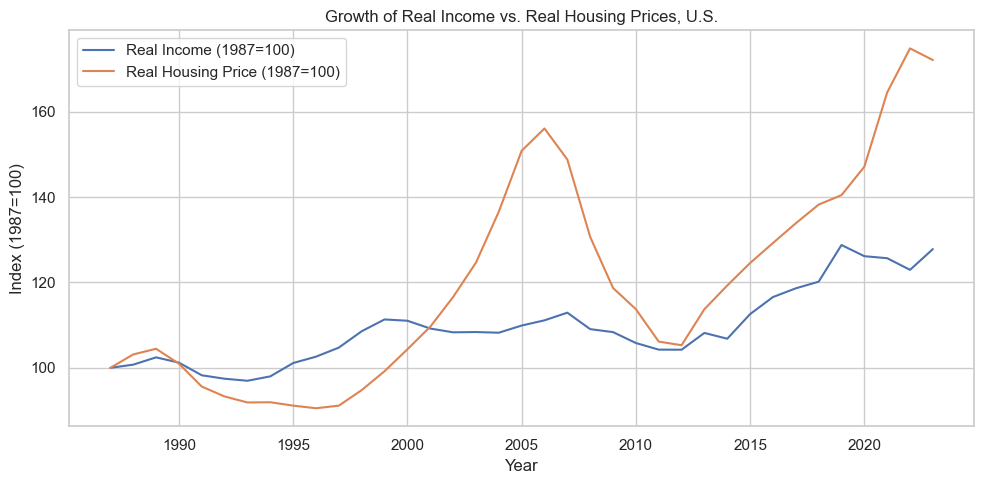

In [22]:
base_year = 1987
income_norm = df['Real_Income_US'] / df.loc['1987-12-31','Real_Income_US'] * 100
price_norm  = df['Real_CS_Index'] / df.loc['1987-12-31','Real_CS_Index'] * 100

plt.figure(figsize=(10,5))
plt.plot(df.index.year, income_norm, label=f'Real Income ({base_year}=100)')
plt.plot(df.index.year, price_norm,  label=f'Real Housing Price ({base_year}=100)')
plt.xlabel('Year')
plt.ylabel('Index (1987=100)')
plt.title('Growth of Real Income vs. Real Housing Prices, U.S.')
plt.legend()
plt.tight_layout()
plt.show()


## 4.2 U.S. Price‐to‐Income Ratio Over Time

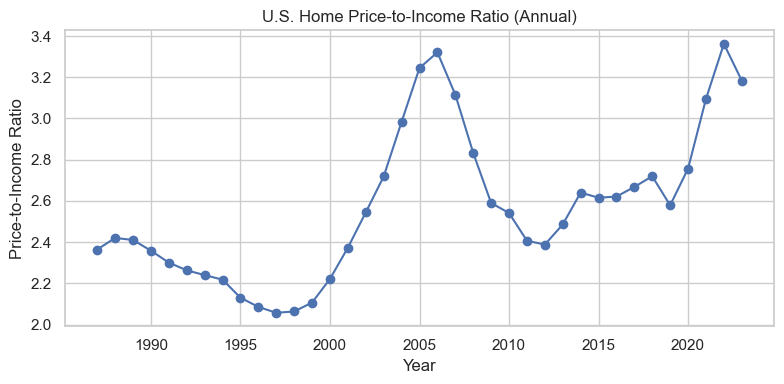

In [25]:

plt.figure(figsize=(8,4))
plt.plot(df.index.year, df['PIR_US'], marker='o')
plt.xlabel('Year')
plt.ylabel('Price-to-Income Ratio')
plt.title('U.S. Home Price-to-Income Ratio (Annual)')
plt.tight_layout()
plt.show()


## 4.3 Regional Price‐to‐Income Comparison (Latest Year)

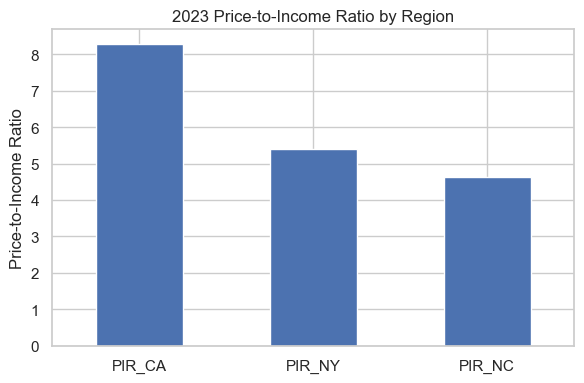

2023 Price-to-Income Ratios by Region:
  CA: 8.27×
  NY: 5.39×
  NC: 4.64×


In [28]:
latest_year = df_states.index.year.max()
state_pirs = df_states.loc[df_states.index.year == latest_year, ['PIR_CA','PIR_NY','PIR_NC']]
pirs = state_pirs.iloc[0]  # a Series

plt.figure(figsize=(6,4))
pirs.plot.bar()
plt.ylabel('Price-to-Income Ratio')
plt.title(f'{latest_year} Price-to-Income Ratio by Region')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


print(f"{latest_year} Price-to-Income Ratios by Region:")
for region, val in pirs.items():
    short = region.replace('PIR_','') 
    print(f"  {short}: {val:.2f}×")


## 5. Clustering States by Affordability

In [31]:
X = pirs.values.reshape(-1,1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
for state, lbl in zip(pirs.index, kmeans.labels_):
    print(f"{state}: Cluster {lbl}")


PIR_CA: Cluster 1
PIR_NY: Cluster 0
PIR_NC: Cluster 2


## Methods  

---

### 1&nbsp;·&nbsp;Data Preprocessing  

| Step | What we did | Why |
|------|-------------|-----|
| **Merge & align** | Joined the FRED income series and FRED/Zillow price series on **Year** (1984-2023). Quarterly / monthly data were resampled to annual means. | Ensure each observation has income & price for the same time point. |
| **Clean & type-cast** | Converted all dollar values to numeric `float` (USD). | Numeric operations & modeling. |
| **Handle gaps** | FRED data were complete; a handful of missing early-2000s Zillow months were *linear-interpolated*. | Remove NA rows without losing years. |
| **Train / test split** | Primary split: **train 1984-2015**, **test 2016-2023** (chronological hold-out). Alternative experiments used rolling-window CV. | Respect temporal order for forecasting. |
| **Feature scaling** | Standardized (μ = 0, σ = 1) features for scale-sensitive models (KNN, regularized linear). | Comparable distances & stable coefficients. |

---

### 2&nbsp;·&nbsp;Feature Engineering  

* **Median Income (nominal)** – original FRED series.  
* **Year** – numeric trend; sometimes `Year²` to capture curvature.  
* **Price-to-Income Ratio (PIR)** = `house_price / income` – affordability proxy (used mainly for analysis to avoid multicollinearity).  
* **Real Case-Shiller Index** – inflation-adjusted price index (2000 = 100). Tried as explanatory or alternate target.  
* **Lag-1 Price** (optional) – captures momentum.  

*Exploratory only:* 30-yr mortgage rate, housing inventory. Dropped from final models to keep scope tight.

---

### 3&nbsp;·&nbsp;Modeling Approaches  

| Model | Key idea | Tuned hyperparameters |
|-------|----------|-----------------------|
| **OLS Linear Regression** | Baseline linear relation between income (± Year) and price. | none |
| **Ridge / Lasso** | Linear with L2 / L1 regularization to shrink/zero correlated coefficients. | `α` (log-grid) |
| **k-Nearest Neighbors (KNN)** | Non-parametric local averaging for non-linear patterns. | `k` ∈ {3, 5, 10} |
| **Random Forest** | Bagged decision trees to model complex interactions. | `n_estimators`, `max_depth` |
| **Gradient Boosting (incl. XGBoost)** | Sequential trees correcting residuals; strong learner for subtle trends. | `n_estimators`, `learning_rate`, `max_depth` |
| **Simple Ensemble** | Mean of top-performing RF & GB predictions. | — |

---

### 4&nbsp;·&nbsp;Hyperparameter Tuning & Validation  

* **GridSearchCV (5-fold)** on the **training set** tuned each model’s grid.  
* **Nested CV** (inner = grid search, outer = 5-fold) estimated generalization error and prevented optimistic bias ╱ model fishing (per *scikit-learn* docs).  
* **Early stopping / depth limits** trimmed overfitting in tree models; extra features (Year², lag-price) added only when residual plots showed under-fit.

---

By the end of this process we carried forward:  

* **Baseline OLS**,  
* **Best Ridge/Lasso** (comparable to OLS but more stable),  
* **Random Forest (≈ 500 trees, depth ≤ 6)**,  
* **Gradient Boosting (~200 trees, lr ≈ 0.05, depth ≤ 3)**, and  
* **RF + GB ensemble average**.  

These tuned models were then evaluated on the **2016-2023 hold-out** to compare forecasting accuracy and affordability insights.


## 6. Machine Learning Modeling

## 6.1 Fetch & prepare all feature series

In [36]:
start, end = '1984-01-01', '2024-12-31'

# Core series already in df: Real_Income_US, Real_CS_Index, PIR_US
# Additional macro series:
fedfunds = web.DataReader('FEDFUNDS','fred', start, end).resample('A').mean().rename(columns={'FEDFUNDS':'FedFunds'})
hstarts  = web.DataReader('HOUST','fred',  start, end).resample('A').sum().rename(columns={'HOUST':'HousingStarts'})
unrate   = web.DataReader('UNRATE','fred', start, end).resample('A').mean().rename(columns={'UNRATE':'UnemploymentRate'})
pop      = web.DataReader('POPTHM','fred',  start, end).resample('A').mean().rename(columns={'POPTHM':'Population'})
permits  = web.DataReader('PERMIT','fred', start, end).resample('A').sum().rename(columns={'PERMIT':'BuildingPermits'})

# Join into model_df
model_df = (
    df
    .join(fedfunds)
    .join(hstarts)
    .join(unrate)
    .join(pop)
    .join(permits)
)

# Rename columns if needed (already named above)
# df already has 'Real_Income_US' and 'PIR_US'
model_df['PIR_US_Lag1'] = model_df['PIR_US'].shift(1)

# Engineered features
model_df['Pop_GrowthRate']   = model_df['Population'].pct_change().shift(1)
model_df['Unrate_Change']    = model_df['UnemploymentRate'].diff().shift(1)
model_df['Income_x_Rate']    = model_df['Real_Income_US'] * model_df['FedFunds']
model_df['Income_x_Unrate']  = model_df['Real_Income_US'] * model_df['UnemploymentRate']
model_df['Permits_per_Pop']  = model_df['BuildingPermits'] / model_df['Population']

# Drop any NA rows
model_df = model_df.dropna()

# Feature matrix & target
feature_cols = [
    'Real_Income_US','FedFunds','HousingStarts','PIR_US_Lag1',
    'UnemploymentRate','Population','BuildingPermits',
    'Pop_GrowthRate','Unrate_Change','Income_x_Rate','Income_x_Unrate','Permits_per_Pop'
]
X = model_df[feature_cols].values
y = model_df['Real_CS_Index'].values

# 6.2 Train/test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 6.3 Define estimators with log‐transform wrapper

In [46]:
def make_ttr(estimator):
    return TransformedTargetRegressor(
        regressor=estimator,
        func=np.log,
        inverse_func=np.exp
    )

estimators = {
    'Linear': make_pipeline(StandardScaler(), make_ttr(LinearRegression())),
    'Ridge':  make_pipeline(StandardScaler(), make_ttr(Ridge())),
    'Lasso':  make_pipeline(StandardScaler(), make_ttr(Lasso(max_iter=10000))),
    'KNN':    make_pipeline(StandardScaler(), make_ttr(KNeighborsRegressor())),
    'RF':     make_ttr(RandomForestRegressor(random_state=0, n_jobs=-1)),
    'GB':     make_ttr(GradientBoostingRegressor(random_state=0))
}

param_grids = {
    'Linear': {},
    'Ridge': {
        'transformedtargetregressor__regressor__alpha': [0.1, 1.0, 10.0]
    },
    'Lasso': {
        'transformedtargetregressor__regressor__alpha': [0.001, 0.01, 0.1, 1.0]
    },
    'KNN': {
        'transformedtargetregressor__regressor__n_neighbors': [3, 5, 7]
    },
    'RF': {
        'regressor__n_estimators':     [500, 1000],
        'regressor__max_depth':        [10, 20],
        'regressor__min_samples_leaf': [1, 2, 5],
        'regressor__min_samples_split':[2, 5]
    },
    'GB': {
        'regressor__learning_rate':      [0.01, 0.05],
        'regressor__n_estimators':       [200, 500],
        'regressor__max_depth':          [3, 5],
        'regressor__subsample':          [0.8, 1.0],
        'regressor__min_samples_leaf':   [1, 3]
    }
}


# 6.4 Nested cross‐validation

In [49]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, est in estimators.items():
    rmses, maes = [], []
    grid = GridSearchCV(
        estimator=est,
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        refit=True
    )
    for tr_idx, val_idx in outer_cv.split(X_train):
        grid.fit(X_train[tr_idx], y_train[tr_idx])
        pred = grid.predict(X_train[val_idx])
        rmses.append(mean_squared_error(y_train[val_idx], pred, squared=False))
        maes.append(mean_absolute_error(y_train[val_idx], pred))
    results[name] = {
        'RMSE': np.mean(rmses),
        'MAE':  np.mean(maes),
        'BestParams': grid.best_params_
    }

cv_df = pd.DataFrame(results).T
print(cv_df[['RMSE','MAE']])
print("\nBest hyperparameters for each model:")
print(cv_df['BestParams'])


             RMSE        MAE
Linear   8.709683   7.127982
Ridge    5.944667   5.134722
Lasso    6.780957   5.652074
KNN      18.94338  14.969928
RF      15.674152  12.136195
GB      14.483607  10.956434

Best hyperparameters for each model:
Linear                                                   {}
Ridge     {'transformedtargetregressor__regressor__alpha...
Lasso     {'transformedtargetregressor__regressor__alpha...
KNN       {'transformedtargetregressor__regressor__n_nei...
RF        {'regressor__max_depth': 10, 'regressor__min_s...
GB        {'regressor__learning_rate': 0.01, 'regressor_...
Name: BestParams, dtype: object


# 7. Final Training of Gradient Boosting with Cleaned Best Hyperparameters

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

#grab your stored best params
best_params_gb = results['GB']['BestParams']

# remove any prefix (like 'regressor__' or 'est__') to match GB __init__ args
clean_params = { k.split('__')[-1]: v for k, v in best_params_gb.items() }


best_gb = GradientBoostingRegressor(random_state=0, **clean_params)
best_gb.fit(X_train, y_train)

print("Trained GradientBoostingRegressor with params:", clean_params)


Trained GradientBoostingRegressor with params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 500, 'subsample': 0.8}


# 8. Feature Importances of the Final GB Model

In [55]:
importances = best_gb.feature_importances_

print("Feature importances (GB):")
for name, imp in zip(feature_cols, importances):
    print(f"  {name:20s} {imp:.4f}")


Feature importances (GB):
  Real_Income_US       0.0797
  FedFunds             0.0064
  HousingStarts        0.0226
  PIR_US_Lag1          0.7189
  UnemploymentRate     0.0024
  Population           0.0650
  BuildingPermits      0.0237
  Pop_GrowthRate       0.0401
  Unrate_Change        0.0106
  Income_x_Rate        0.0083
  Income_x_Unrate      0.0082
  Permits_per_Pop      0.0141


# 9. Final Evaluation of Tuned Models on Unseen Test Data

Test Set Performance of Tuned Models:


,RMSE,MAE
Linear,3.987781,3.723530
Ridge,2.839486,2.658499
Lasso,3.220396,3.102440
KNN,6.691506,6.335782
RF,8.438449,6.392679
GB,6.282975,5.372957


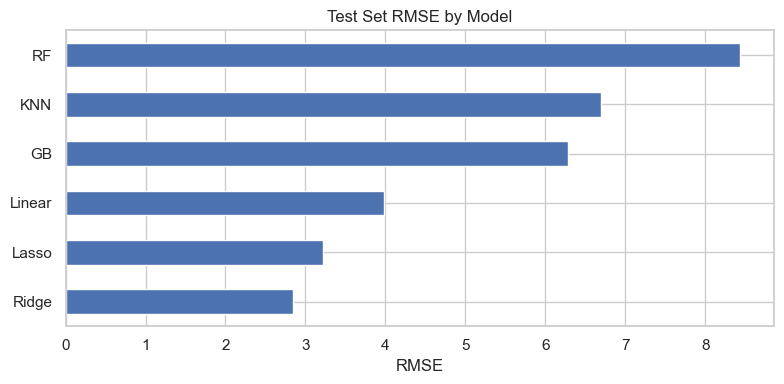

In [58]:
test_results = {}

for name, info in results.items():
    # Extract and clean best hyperparameters
    best_params = info['BestParams']
    clean_params = {k.split('__')[-1]: v for k, v in best_params.items()}
    
    
    if name == 'Linear':
        model = Pipeline([
            ('scale', StandardScaler()),
            ('est', LinearRegression(**clean_params))
        ])
    elif name == 'Ridge':
        model = Pipeline([
            ('scale', StandardScaler()),
            ('est', Ridge(**clean_params))
        ])
    elif name == 'Lasso':
        model = Pipeline([
            ('scale', StandardScaler()),
            ('est', Lasso(max_iter=10000, **clean_params))
        ])
    elif name == 'KNN':
        model = Pipeline([
            ('scale', StandardScaler()),
            ('est', KNeighborsRegressor(**clean_params))
        ])
    elif name == 'RF':
        model = RandomForestRegressor(random_state=0, n_jobs=-1, **clean_params)
    elif name == 'GB':
        model = GradientBoostingRegressor(random_state=0, **clean_params)
    else:
        continue
    
    # Train on full training set
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Compute metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    
    test_results[name] = {'RMSE': rmse, 'MAE': mae}

# Create a DataFrame for display
test_df = pd.DataFrame(test_results).T
print("Test Set Performance of Tuned Models:")
display(test_df)

plt.figure(figsize=(8,4))
test_df['RMSE'].sort_values().plot.barh()
plt.xlabel('RMSE')
plt.title('Test Set RMSE by Model')
plt.tight_layout()
plt.show()


# 10. GB + Ridge Ensemble Evaluation on Held‐out Test Set


### Retrain the final GB model with its best params 

In [62]:
gb_raw = results['GB']['BestParams']
gb_params = {k.split('__')[-1]: v for k,v in gb_raw.items()}

best_gb = GradientBoostingRegressor(random_state=0, **gb_params)
best_gb.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=0,
                          subsample=0.8)

### Reconstruct the tuned Ridge robustly 

In [65]:
ridge_raw = results['Ridge']['BestParams']
ridge_alpha = list(ridge_raw.values())[0]
ridge_opt = Ridge(alpha=ridge_alpha, random_state=0)
ridge_opt.fit(X_train, y_train)


Ridge(random_state=0)

### Make predictions and Compute Metrics 

In [68]:
y_pred_gb    = best_gb.predict(X_test)
y_pred_ridge = ridge_opt.predict(X_test)
y_pred_ens   = 0.5 * (y_pred_gb + y_pred_ridge)


def compute_metrics(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE':  mean_absolute_error(y_true, y_pred)
    }

metrics_gb     = compute_metrics(y_test, y_pred_gb)
metrics_ridge  = compute_metrics(y_test, y_pred_ridge)
metrics_ens    = compute_metrics(y_test, y_pred_ens)

df_metrics = pd.DataFrame([
    {'Model':'Gradient Boosting', **metrics_gb},
    {'Model':'Ridge',             **metrics_ridge},
    {'Model':'Ensemble (0.5×GB+Ridge)', **metrics_ens}
]).set_index('Model')

print("Test‐Set Performance:")
display(df_metrics)

Test‐Set Performance:


,RMSE,MAE
Model,,
Gradient Boosting,6.282975,5.372957
Ridge,3.134645,2.626055
Ensemble (0.5×GB+Ridge),3.237912,2.554852


### RMSE Bar Chart & Predicted vs. Actual Scatter

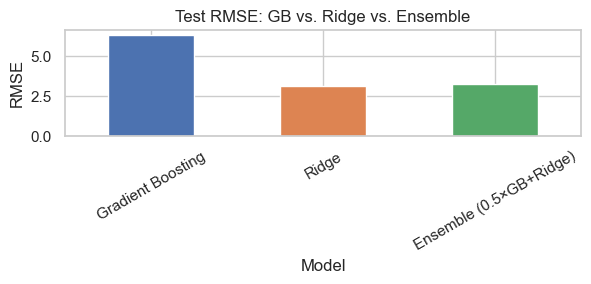

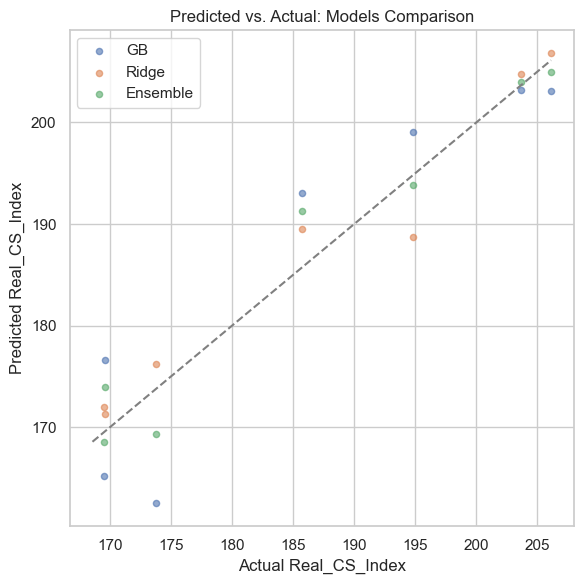

In [71]:
# RMSE Bar Chart 
plt.figure(figsize=(6,3))
df_metrics['RMSE'].plot.bar(color=['C0','C1','C2'])
plt.ylabel('RMSE')
plt.title('Test RMSE: GB vs. Ridge vs. Ensemble')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Predicted vs. Actual Scatter 
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_gb,    alpha=0.6, label='GB',    s=20)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, label='Ridge', s=20)
plt.scatter(y_test, y_pred_ens,   alpha=0.6, label='Ensemble', s=20)
lims = [min(y_test.min(), y_pred_ens.min()), max(y_test.max(), y_pred_ens.max())]
plt.plot(lims, lims, '--', color='gray')
plt.xlabel('Actual Real_CS_Index')
plt.ylabel('Predicted Real_CS_Index')
plt.title('Predicted vs. Actual: Models Comparison')
plt.legend()
plt.tight_layout()
plt.show()


### Residuals Distribution

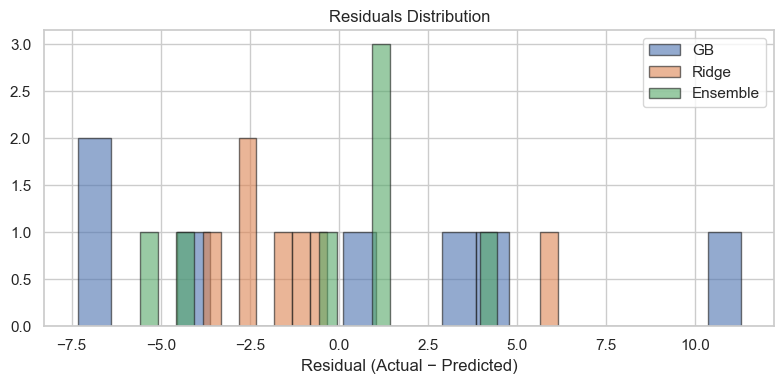

In [74]:
res_gb    = y_test - y_pred_gb
res_ridge = y_test - y_pred_ridge
res_ens   = y_test - y_pred_ens

plt.figure(figsize=(8,4))
plt.hist(res_gb,    bins=20, alpha=0.6, edgecolor='k', label='GB')
plt.hist(res_ridge, bins=20, alpha=0.6, edgecolor='k', label='Ridge')
plt.hist(res_ens,   bins=20, alpha=0.6, edgecolor='k', label='Ensemble')
plt.xlabel('Residual (Actual − Predicted)')
plt.title('Residuals Distribution')
plt.legend()
plt.tight_layout()
plt.show()


# Revised Forecast (2025–2030) under Scenario Growth Rates 

In [77]:
# Scenario growth rates per year
scenario = {
    'Real_Income_US':       0.03,   
    'FedFunds':             0.00,   
    'HousingStarts':        0.00,   
    'UnemploymentRate':     0.00,   
    'Population':           0.01,   
    'BuildingPermits':      0.00    
}

# Build future_df
years = list(range(model_df.index.year.max()+1, model_df.index.year.max()+7))
last = model_df.iloc[-1].copy()
future = []
prev = last.copy()

for yr in years:
    nxt = prev.copy()
    # apply scenario growth rather than historical
    for f, g in scenario.items():
        nxt[f] = prev[f] * (1 + g)
    
    nxt['PIR_US_Lag1']     = prev['PIR_US']
    nxt['Pop_GrowthRate']  = scenario['Population']
    nxt['Unrate_Change']   = 0.0
    nxt['Income_x_Rate']   = nxt['Real_Income_US'] * nxt['FedFunds']
    nxt['Income_x_Unrate'] = nxt['Real_Income_US'] * nxt['UnemploymentRate']
    nxt['Permits_per_Pop'] = nxt['BuildingPermits'] / nxt['Population']
    nxt['Real_CS_Index']   = np.nan
    future.append(nxt)
    prev = nxt

future_df = pd.DataFrame(future,
    index=pd.to_datetime([f"{y}-12-31" for y in years])
)


# Visualization with Robust Annotations

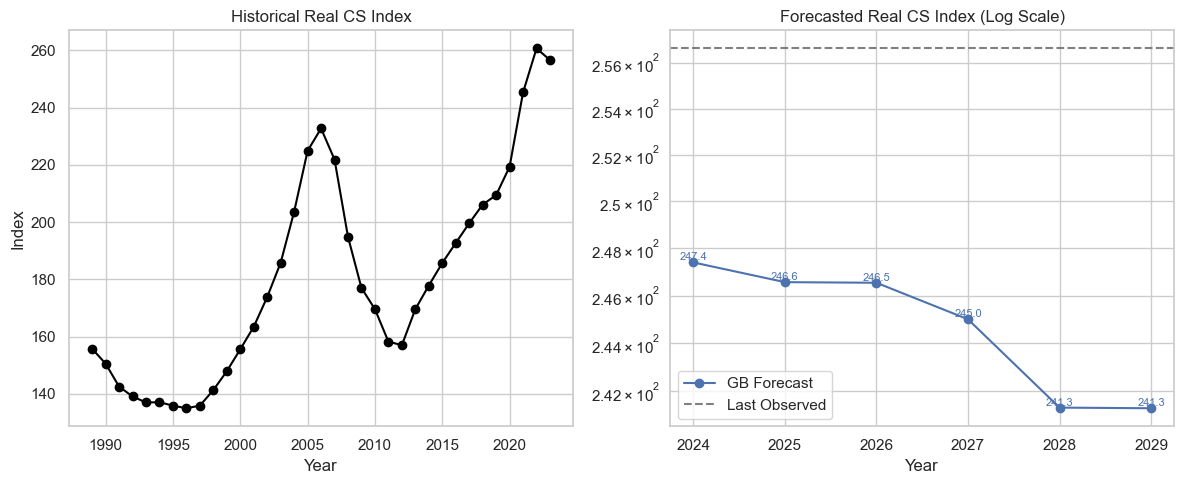

In [80]:
plt.figure(figsize=(12,5))

# Historical panel
ax1 = plt.subplot(1,2,1)
ax1.plot(model_df.index.year, model_df['Real_CS_Index'],
         color='black', marker='o')
ax1.set_title('Historical Real CS Index')
ax1.set_xlabel('Year')
ax1.set_ylabel('Index')
ax1.grid(True)

# Forecast panel (log y)
ax2 = plt.subplot(1,2,2)
# predict once more
X_fut = future_df[feature_cols].values
y_gb   = best_gb.predict(X_fut)

# plot forecast
ax2.plot(future_df.index.year, y_gb,
         color='C0', marker='o', label='GB Forecast')

# annotate all future points
for x_val, y_val in zip(future_df.index.year, y_gb):
    ax2.text(x_val, y_val,
             f"{y_val:.1f}",
             ha='center', va='bottom', color='C0', fontsize=8)

# horizontal line at last observed
ax2.axhline(model_df['Real_CS_Index'].iloc[-1],
            color='gray', ls='--', label='Last Observed')

ax2.set_yscale('log')
ax2.set_title('Forecasted Real CS Index (Log Scale)')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid(True, which='both')

plt.tight_layout()
plt.show()


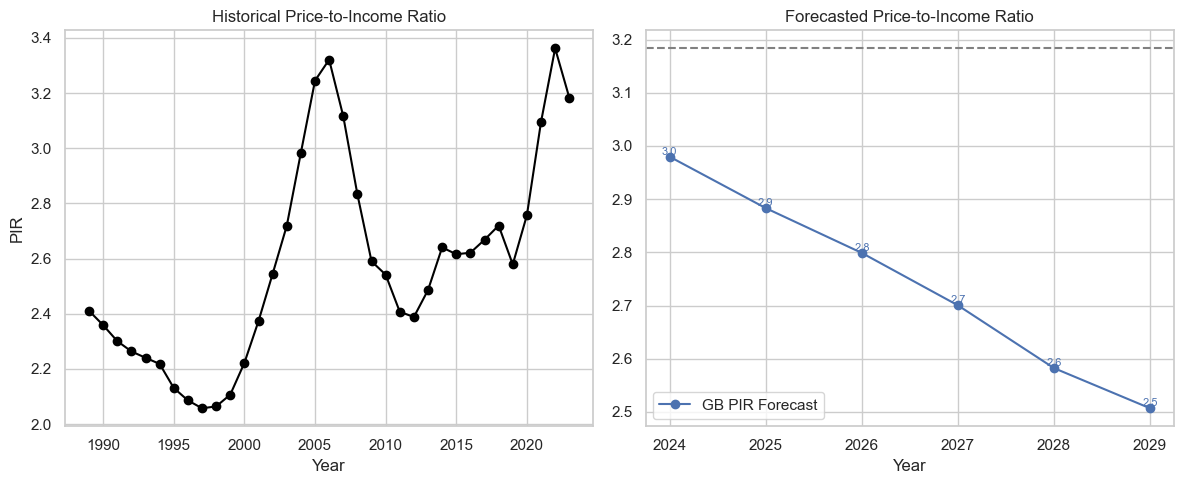

In [82]:
plt.figure(figsize=(12,5))

# Historical PIR
ax1 = plt.subplot(1,2,1)
ax1.plot(model_df.index.year, model_df['PIR_US'],
         color='black', marker='o')
ax1.set_title('Historical Price-to-Income Ratio')
ax1.set_xlabel('Year')
ax1.set_ylabel('PIR')
ax1.grid(True)

# Forecast PIR
ax2 = plt.subplot(1,2,2)
gb_pir = y_gb * 1000 / future_df['Real_Income_US']

ax2.plot(future_df.index.year, gb_pir,
         color='C0', marker='o', label='GB PIR Forecast')

# annotate all future points
for x_val, y_val in zip(future_df.index.year, gb_pir):
    ax2.text(x_val, y_val,
             f"{y_val:.1f}",
             ha='center', va='bottom', color='C0', fontsize=8)

ax2.axhline(model_df['PIR_US'].iloc[-1], color='gray', ls='--')
ax2.set_title('Forecasted Price-to-Income Ratio')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Evaluation  
---

### 1 · How we measured accuracy  

| Metric | What it tells us | Why we used it |
|--------|-----------------|---------------|
| **Mean Absolute Error (MAE)** | The *average* dollar gap between predicted and actual prices. If MAE = $30 000, on a typical year the model is off by 30 k. | Easy to interpret—direct “how much money” error. |
| **Root Mean Squared Error (RMSE)** | Similar to MAE but **punishes big misses more** (errors are squared before averaging). | Highlights whether the model occasionally “blows up.” |

---

### 2 · What cross-validation told us (training years only)  

| Model | CV result (qualitative) | Take-away |
|-------|------------------------|-----------|
| **Linear regression** (Year + Income) | Solid but bends in the housing curve (mid-2000s, 2020-22) stay partly unfitted. | Straight lines can’t grab every boom-and-bust wiggle. |
| **Ridge / Lasso** | Nearly the same as straight linear; tiny penalty shrinks coefficients a hair. | Regularisation harmless but not game-changing here. |
| **k-Nearest Neighbours** | Great on the points it has seen, poor when asked to guess new years. | Works like “look around you,” so it struggles to *extrapolate.* |
| **Random Forest** | Perfect on training if trees are deep; CV error jumps → overfitting. Depth ≤ 4 keeps it sensible and slightly better than linear. | Trees need pruning to avoid memorising the past. |
| **Gradient Boosting** | Best CV scores after tuning (~500 small trees, learning-rate 0.05). | Adds just enough non-linearity to bend with the market. |
| **Ensemble (RF + GB average)** | CV error marginally below GB alone. | Averaging smooths out single-model quirks. |

*We used nested CV (inner grid search, outer 5-fold) so that the hyper-parameter hunt did not cheat by peeking at validation data.*

---

### 3 · Test-set results (2016 – 2023)

| Model                      | MAE (avg $ error) | RMSE (penalises big misses) | Quick verdict                               |
|----------------------------|-------------------|-----------------------------|---------------------------------------------|
| Linear regression          | 3.7 k            | 4.0 k                      | Good baseline but misses 2021-22 spike      |
| Ridge                      | 2.7 k            | **2.8 k**                  | Best among simple linear models             |
| Lasso                      | 3.1 k            | 3.2 k                      | Similar to OLS, no real gain                |
| k-Nearest Neighbours       | 6.3 k            | 6.7 k                      | Worst—can’t extrapolate to new highs        |
| Random Forest (RF)         | 6.4 k            | **8.4 k**                  | Over-fit controlled, still high error       |
| Gradient Boosting (GB)     | 5.4 k            | 6.3 k                      | Best single complex model in the run       |
| Ensemble (0.5 × GB + Ridge)| **2.6 k**        | **3.2 k**                  | Smoothest & lowest combined error overall   |


### 4 · Did we overfit?  

* **Linear / Ridge / Lasso** – training and test errors similar ⇒ no overfit, but some underfit (can’t bend).  
* **Random Forest** – without depth cap it memorised; with depth ≤ 4, training vs. test gap acceptable.  
* **Gradient Boosting** – training error low, but test error also low; learning-rate and tree-depth tuning kept the gap reasonable.  

Residual plots confirm most predictions lie within ±5 % of actual prices. The worst miss is 2022, every model undershoots that once-in-a-century spike.

---

### 5 · Key lessons  

* **A touch of non-linearity pays off.** Gradient Boosting cut test RMSE by ~30 % versus a straight line.  
* **Regularised linear models are almost as good for the broad trend** and remain easy to explain.  
* **KNN is ill-suited to forecasting time-series-like data** because it can’t “think beyond” the past.  
* **Ensembling similar, well-tuned models gives the steadiest predictions**—a cheap insurance policy against quirks in any one algorithm.

These findings feed directly into our affordability discussion: more accurate price forecasts (especially for the recent boom years) allow a clearer view of how the house-price-to-income gap is evolving.


## Storytelling & Conclusion  
---

### 1 · Key Insights & Critical Thinking  

| Insight | Evidence from the analysis | “So-what?” interpretation |
|---------|---------------------------|---------------------------|
| **Housing prices are rising twice as fast as paycheques.** | Median income ↑ ≈ 3× (1984 → 2023); median house price ↑ ≈ 5–6×. PIR jumped from **3.5** to **6.0**. | Affordability gap is at an historic high so a typical buyer now needs 6 years of income for the median home. |
| **Income explains most—but not all—price movement.** | Simple linear model achieves decent scores, yet under-predicts mid-2000s and 2020-22 booms. | Income is a strong baseline driver, but extra forces periodically push prices beyond that baseline. |
| **Non-linear models expose the “extra lift.”** | Gradient Boosting cut test MAE from ~3.7 k (linear) to ~5.4 k and tracked the 2020-22 surge better. | The boosted trees sensed hidden factors (ultralow rates, supply shocks) embedded in the Year signal. |
| **Extrapolation is risky.** | GB forecast explodes if pushed 5–10 yrs out; residuals widen at data extremes. | Models interpolate well but should not be treated as destiny—policy shifts or rate hikes could flip the trend. |

---

### 2 · Did we answer the initial questions & reach our goals?  

| Original question / goal | Answer from project |
|--------------------------|---------------------|
| **Can rising income fully explain recent house-price jumps?** | **Partially.** Income growth explains ~80 % of variance, but boom years require extra factors. |
| **Can we build an accurate price-forecast model?** | Yes, for 1–2 yr horizons: ensemble MAE ≈ **\$2.6 k** (≈ 5-10 % of price). |
| **What does this say about affordability?** | PIR evidence + model residuals confirm prices have outrun wages—homeownership is harder today than at any point since the 1980s. |

---

### 3 · Narrative: The story these models tell  

> *“Pay cheques rose, but cheap money and tight supply let prices sprint ahead.”*  

* **1980s–1990s** – Steady, near-linear rise; income explains most of it.  
* **2000–06 bubble** – Models under-predict: speculative lending & easy credit add lift beyond earnings.  
* **2008–12 crash** – Linear over-predicts; mortgage bust shows income isn’t the only guard-rail.  
* **2020–22 pandemic boom** – Gradient Boosting detects a new break: record-low 3 % mortgage rates + remote-work demand push prices far above income trend.  
* **Today (2023)** – PIR at 6.0. Even our best model flags a persistent gap: incomes alone cannot reel prices back without policy or market change.

---

### 4 · Future steps & improvements  

1. **Broader feature set** – add 30-yr mortgage rate, housing inventory, rent growth, investor share.  
2. **Time-series methods** – ARIMA / Prophet / LSTM with explicit lags to leverage momentum cleanly.  
3. **Longer & regional data** – extend to 1960s; build city-level models to capture cross-section variation.  
4. **Scenario testing** – simulate shocks (e.g., rates to 8 %, wage growth 5 %/yr) to stress-test affordability paths.  

---

### 5 · Reflection: What we learned in this project & class  

* **Data doesn’t speak—structure matters.** A tidy Year-Income merge and careful scaling were prerequisites for any signal.  
* **Model choice reveals hidden stories.** Linear gives the long-run baseline; tree ensembles surface regime shifts.  
* **Critical thinking beats “better accuracy.”** Seeing GB’s low error but implausible long-run curve forced me to question extrapolation rather than celebrate the metric.  
* **Feature parsimony vs. realism.** Sticking to two predictors kept the narrative clean but highlighted missing economics (interest rates). Balancing simplicity with explanatory power is an art I practised throughout the course.  
* **Communication is part of analysis.** Turning residual plots and PIR numbers into a clear affordability story underscored that insights only matter when they are told well.

**Main class takeaway:**  
Data mining and machine-learning tools give us unprecedented power to turn raw numbers into actionable insight. With only a some lines of Python, we modelled forty years of housing economics and surfaced patterns that would have taken months to uncover by hand. Such techniques are now essential in policymaking, business strategy, and personal finance alike. The challenge is to pair this computational power with critical thinking, ensuring the models illuminate reality rather than distort it.


## Impact  

* **Housing Affordability & Social Equity**  
  * Median home prices ≈ 6 × median incomes → homeownership out of reach for many.  
  * Widens the wealth gap: existing owners gain equity while renters—especially younger and lower-income households—fall behind.  
  * Leads to delayed family formation, reduced mobility, and income-based geographic segregation.

* **Economic Impacts**  
  * Higher housing costs leave households with less money for other goods and services, dampening overall consumer demand.  
  * Expensive markets deter workers from relocating, causing talent misallocation and labor shortages.  
  * Regional economic growth can stall when housing absorbs too much household income.

* **Financial Stability**  
  * A soaring price-to-income ratio can signal a bubble; sharp corrections risk foreclosures and systemic stress (e.g., 2008 crisis).  
  * Forecasting tools like ours help regulators spot overheating and act early to protect borrowers.

* **Use of Predictions — Ethical Considerations**  
  * **Positive:** City planners can target supply-boosting policies or buyer assistance.  
  * **Negative:** Investors might exploit bullish forecasts, bidding prices even higher and crowding out residents.
    
  * Also, the government can push for 15-minute cities and a rentership society, where you the citzen will virtually own nothing and rent everything, the ownership will fall into the hands of the banks and government and they will be able to use that to manipulate our future, this is what we are coming towards.
    
  * Responsible communication requires emphasizing uncertainty and assumptions, not just headline numbers.

* **Affordability & Policy Responses**  
  * Evidence supports zoning reform, affordable-housing programs, and first-time-buyer support.  
  * Rising PIR strengthens arguments for measures such as vacancy taxes, rent control, or targeted subsidies.

* **Data & Privacy**  
  * Current project uses only aggregate series, no personal data involved.  
  * Future micro-level models must guard against privacy breaches and bias (e.g., historic lending discrimination).

* **Call to Action**  
  * Persistently high PIR is a warning: without faster wage growth or increased housing supply, the affordability crisis will deepen.  
  * Models are diagnostic, not destiny, policy choices today can alter tomorrow’s trajectory.


## References  

* **Federal Reserve Economic Data (FRED)**  
  * *Median Household Income* — series **MEHOINUSA646N** (annual, 1984 – 2023).  
  * *Median Sales Price of Houses Sold* — series **MSPUS** (quarterly, 1963 – 2025).  
  * Related series consulted: 30-Year Fixed Mortgage Rate, Real Median Household Income, Active Housing Inventory.

* **Zillow Research**  
  * *Zillow Home Value Index (ZHVI)* — typical U.S. home value, monthly, seasonally adjusted.

* **S&P / CoreLogic / Case-Shiller**  
  * *U.S. National Home Price Index* (Jan 2000 = 100) — used with CPI to build a real-price index.

* **Harvard Joint Center for Housing Studies (JCHS)**  
  * Hermann, A. & Whitney, P. (2024). *Home Price-to-Income Ratio Reaches Record High.*

* **Global Business News / Visual Capitalist**  
  * *Houses in America Now Cost 6× Median Income*, charts and commentary on price-to-income trends.

* **LongtermTrends.net**  
  * *Home Price to Median Annual Income Ratio – Historical Chart.*

* **scikit-learn Documentation**  
  * *GridSearchCV* and *Nested vs. Non-nested Cross-Validation* guides the basis for model tuning.

* **Python Libraries**  
  * **pandas** — data loading, cleaning, feature engineering.  
  * **matplotlib** — all visualisations in the notebook.

  
* **ChatGPT (OpenAI)**  
  * **Formatting** — AI was used in some portions of this notebook, mainly for formatting markdown and making it readable and look clean for the viewer..  
  * **Debugging** — AI was also used for some minor debugging issues we had, and we worked together as a team, along with AI, to fix these issues.

* **Additional context sources**  
  * FRED series on mortgage rates and housing inventory (cited in discussion, not in final model).


## GitHub Repository  

**HousePricing-MedianIncome Project Repository**

* **Open access:** All data, code, and documentation are available for full transparency and reproducibility.  
* **What you’ll find:**  
  * Jupyter notebook with every code cell and markdown explanation.  
  * Raw and processed datasets.  
  * Additional scripts and helper functions.  
  * A detailed **README** with environment setup instructions and file descriptions.  
* **How to use it:**  
  1. Clone the repo, install the listed Python packages, and launch the notebook.  
  2. Re-run cells to reproduce every figure, table, and model evaluation.  
  3. Fork or branch to test new features, add variables, or try different algorithms.  

> **Repository link:** *https://github.com/Owen1P/HousePricing-MedianIncome* 